In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ..utils import get_data, sample_normal_data
import pandas as pd
import seaborn as sns
sns.set_style("white")

This file is used for visualizing the distribution of normal and anomaly data in latent space.

In [6]:
from ..utils import SlidingWindowDataset
# load data and model
window_size, target_dims = 20, None
dataset = "ETL"
(train_data, _), (test_data, label) = get_data(dataset, normalize=True)
train_dataset = SlidingWindowDataset(train_data, window_size, target_dims)
test_dataset = SlidingWindowDataset(test_data, window_size, target_dims)
label = label[window_size:] if label is not None else None
model = torch.load(f"./output/{dataset}/VAE_MODEL.pt")
sample_index = np.load(f"./output/{dataset}/sample_index_VAE_MODEL.npy")

load data of: ETL
train:  0 None
test:  0 None
Data normalized
Data normalized
train set shape:  (54361, 12)
test set shape:  (20881, 12)
test set label shape:  (20881,)


In [7]:
from torch.utils.data import SubsetRandomSampler, DataLoader

def get_data_by_index(datasets, index):
    sampler = SubsetRandomSampler(index)
    dataloader = DataLoader(datasets, batch_size=1, sampler=sampler)
    data = []
    for x, y in dataloader:
        data.append(x)
    return data



In [13]:

unsample_index = np.setdiff1d(np.where(label > 0), sample_index)
seen_anomaly_data = get_data_by_index(test_dataset, sample_index)[-20:]
unseen_anomaly_data = get_data_by_index(test_dataset, unsample_index)[-20:]
normal_data = sample_normal_data(test_dataset, 0.1)[:20]

model.eval()
# data's distribution in latent space
def generate_points(arr):
    x = []
    y = []
    for data in arr:
        data = data.cuda()
        outputs = model(data)
        x.append(torch.pow(outputs[0], 2).mean().item())
        y.append(torch.exp(outputs[1]).mean().item())
    return [x, y]

normal_points = generate_points(normal_data)
seen_anomaly_points = generate_points(seen_anomaly_data)
unseen_anomaly_points = generate_points(unseen_anomaly_data)
# use a dataframe to save data for it is easier to draw with a dataframe.
df = pd.DataFrame({'x': normal_points[0] + seen_anomaly_points[0] + unseen_anomaly_points[0], 'y': normal_points[1] + seen_anomaly_points[1] + unseen_anomaly_points[1], 'category': ['normal']*20+['seen_anomaly']*20+['unseen_anomaly']*20})


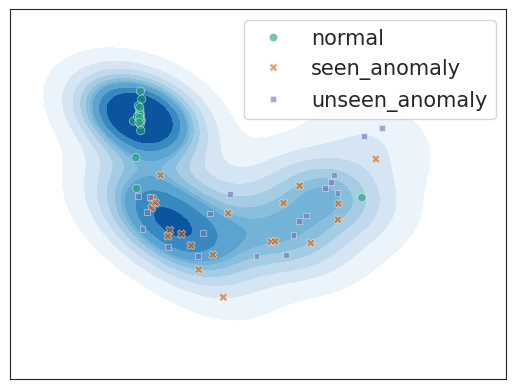

In [21]:
# enhance randomness with a jitter function
def jitter(values,j=0):
    return values + np.random.normal(j,0.01,values.shape)

x, y = jitter(df.x), jitter(df.y)
sns.kdeplot(x=x, y=y,cmap="Blues", fill=True)
sns.scatterplot(x=x, y=y,hue="category", style="category",palette='Dark2', data=df, alpha=0.6)
plt.legend(title=None, fontsize=15)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.show()